# Model Prediction Analysis

This notebook analyzes the similarity between stimulation-induced and spontaneous seizures using machine learning predictions and electrographic features.

In [109]:
# Import libraries and set up analysis environment
# This cell imports all necessary libraries for data analysis, visualization, and statistical modeling

# Standard library
import warnings

# Scientific computing
import numpy as np
import pandas as pd
import scipy as sc

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']  # Custom color palette for consistency

# Statistical analysis
from scipy import stats
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

# Machine learning metrics for seizure similarity analysis
from sklearn.metrics import cohen_kappa_score, f1_score, matthews_corrcoef

# File system utilities
from os.path import join as ospj
from os.path import exists as ospe

# Project-specific utilities
from utils import *

# Path setup and configuration
warnings.filterwarnings('ignore')
from config import Config
prodatapath,metapath,figpath = Config.deal(['prodatapath','metapath','figpath'])


## Workspace Preparation

Setting up constants and loading core datasets for seizure similarity analysis.

In [110]:
# Set percentile threshold for data aggregation across seizures
# This controls how seizure-level metrics are combined at the patient level
COMBINER = 75

In [111]:
# Load seizure metadata from BIDS-formatted CSV file
# Contains information about seizure types, timing, and stimulation parameters
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information_BIDS.csv'))

In [112]:
# Load LSTM model predictions and seizure annotations
# This cell loads the main dataset containing machine learning predictions of seizure onset channels

mdl_str = 'LSTM'
data_str = "optimized_predicted_channels_LSTM_tuned_thresholds_v4_sz-mean_pt-mean_smooth-med.pkl"
sz_annots = pd.read_pickle(ospj(prodatapath,data_str))

# Exclude CHOP015 due to data quality issues
sz_annots = sz_annots[sz_annots.Patient != 'CHOP015']

# Standardize column naming convention
sz_annots.columns = [col if col != 'Patient' else 'patient' for col in sz_annots.columns]

# Sort by seizure onset time for temporal analysis
sz_annots.sort_values('approximate_onset',inplace=True)

## Seizure Annotation Preparation

Processing and merging seizure annotations with clinical metadata to prepare for similarity analysis.

### Merging annotations and seizure metadata

Combining machine learning predictions with clinical seizure annotations and stimulation information.

In [113]:
# Load and process clinical seizure annotations
# Merge with LSTM predictions using temporal matching

# Load manual seizure annotations from clinicians
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)

# Standardize column names for consistency
seizures_df.rename(columns=dict(Patient='patient',IEEGname='iEEG_ID'),inplace=True)

# Fill missing onset times using alternative onset markers in order of preference
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)  # Unequivocal Electrographic Onset
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)  # Earliest Electrographic Change
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)

# Exclude high-frequency stimulation induced seizures (stim = 2)
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)

# Merge annotations with LSTM predictions using time-based matching
# Uses merge_asof for temporal alignment with 240-second tolerance
sz_annots = pd.merge_asof(sz_annots,
            seizures_df[['approximate_onset','patient',"iEEG_ID","typical","stim_channels"]],
            on='approximate_onset',by=['patient','iEEG_ID'],
            tolerance = 240,  # 4-minute tolerance for matching
            direction='nearest')

sz_annots.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

### Mapping channels to regions and adding stim channels

Processing electrode channel information and mapping to brain regions for spatial analysis.

In [114]:
# Process stimulation channels and update seizure channel lists
# Add stimulation electrodes to the analysis when STIMFLAG is enabled

STIMFLAG=True  # Flag to include stimulation channels in analysis
pt_groups = sz_annots.groupby('patient')

for pt, group in pt_groups:
    # Load electrode-to-region mapping for this patient
    region_path = get_rpath(prodatapath, pt)
    if ospe(region_path):
        electrode_regions = pd.read_pickle(region_path)

    pt_stim_chs = set()  # Track all stimulation channels for this patient

    for idx, row in group.iterrows():
        # Parse stimulation channel names if available
        if STIMFLAG and isinstance(row.stim_channels, str):
            stim_chs = clean_labels(row.stim_channels.split('-'), '')
            pt_stim_chs.update(stim_chs)

        # For stimulation-induced seizures, add stim channels to seizure channel list
        if STIMFLAG and row.stim == 1:
            sz_annots.at[idx, 'sz_chs'] = np.concatenate([row.sz_chs, stim_chs])
            sz_annots.at[idx, 'sz_times'] = np.concatenate([row.sz_times, [0, 0]])  # Stim occurs at time 0

    # Create unified channel list including all annotated channels and stimulation channels
    all_annotated_channels = set.union(*[set(chs) for chs in group['all_channels']])
    all_annotated_channels.update(pt_stim_chs)
    final_all_channels = np.array(sorted(all_annotated_channels))

    # Ensure consistent channel lists across all seizures for this patient
    for idx in group.index:
        sz_annots.at[idx, 'all_channels'] = final_all_channels


In [115]:
# Map electrode channels to brain regions and create channel/region masks
# This creates binary masks for different seizure onset definitions

sz_annots[['all_rs','sz_rs']] = None
sz_annots[['all_rs','sz_rs']] = sz_annots[['all_rs','sz_rs']].astype(object)
for idx, row in sz_annots.iterrows():
    pt = row.patient
    region_path = get_rpath(prodatapath, pt)
    if ospe(region_path):
        electrode_regions = pd.read_pickle(region_path)

        # Map all channels to brain regions, excluding white matter and empty labels
        all_rs = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label']
        all_rs = [r for r in all_rs.unique() if ((r != 'EmptyLabel') and ('white' not in r.lower()) and ('wm' not in r.lower()))]
        sz_annots.at[idx, 'all_rs'] = all_rs

        # Map seizure channels to their corresponding brain regions
        labels = []
        for ch in row.sz_chs:
            match = electrode_regions[electrode_regions.name == ch]['label']
            labels.append(match.values[0])

        sz_annots.at[idx, 'sz_rs'] = labels

        # Create binary masks for different onset channel definitions
        # UEO = Unequivocal Electrographic Onset, SEC = Secondary spread
        for col in ['ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict', 'sec_chs_loose']:
            chs = row[col]
            if STIMFLAG and (sz_annots.loc[idx, 'stim'] == 1):
                stim_chs = clean_labels(row.stim_channels.split('-'), '')
                chs = np.concatenate((chs,stim_chs))
            # Create channel-level binary mask
            sz_annots.at[idx, col + '_mask'] = np.atleast_1d([ch in chs for ch in row['all_channels']])
            
            # Map channels to regions and filter out white matter
            electrode_locals = electrode_regions[electrode_regions.name.isin(chs)]['label']
            electrode_locals = [r for r in electrode_locals if ((r != 'EmptyLabel') and ('white' not in r.lower()) and ('wm' not in r.lower()))]

            # Create region-level arrays and masks
            all_rs = sz_annots.loc[idx, 'all_rs']
            sz_annots.at[idx, col.replace('chs', 'rs')] = np.atleast_1d(electrode_locals)
            sz_annots.at[idx, col.replace('chs', 'rs') + '_mask'] = np.atleast_1d([l in electrode_locals for l in all_rs])
    else:
        print(f"No region mapping found for {pt}")
# Clean up data: remove seizures without stimulation info and create region-specific dataset
sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['approximate_onset'],inplace=True)
sz_annots_rs = sz_annots.dropna(axis=0,subset=['all_rs']).copy()  # Dataset with region mappings

### Seizure Metadata

Summary statistics about the dataset composition and patient exclusions.

Patient Exclusion Criteria:
- HUP274, HUP282, CHOP036, CHOP047: No spontaneous seizures recorded
- CHOP015, CHOP032, CHOP038, CHOP046: Technical errors preventing spontaneous seizure upload


In [116]:
# Generate dataset summary statistics
# Print counts of patients, seizures, and stimulation-induced seizures by center

print("Total unique patients:", sz_annots.patient.nunique())
print("HUP patients:", sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)].patient.nunique())
print("Total HUP seizures:", len(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)]))
print("Total CHOP seizures:", len(sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x)]))
print("Total stimulation-induced seizures:", sz_annots[sz_annots.stim==1].approximate_onset.nunique())
print("HUP stimulation-induced seizures:", sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x) & (sz_annots.stim==1)].approximate_onset.nunique())
print("CHOP stimulation-induced seizures:", sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x) & (sz_annots.stim==1)].approximate_onset.nunique())

Total unique patients: 30
HUP patients: 19
Total HUP seizures: 334
Total CHOP seizures: 107
Total stimulation-induced seizures: 43
HUP stimulation-induced seizures: 23
CHOP stimulation-induced seizures: 20


In [117]:
# Display sorted list of all patients included in the analysis
np.sort(sz_annots.patient.unique())

array(['CHOP005', 'CHOP010', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035',
       'CHOP037', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP224',
       'HUP225', 'HUP229', 'HUP230', 'HUP235', 'HUP238', 'HUP246',
       'HUP247', 'HUP249', 'HUP250', 'HUP253', 'HUP257', 'HUP261',
       'HUP263', 'HUP266', 'HUP267', 'HUP273', 'HUP275', 'HUP288'],
      dtype=object)

## Stimulation-Spontaneous Electrographic Similarity

Analyzing the similarity between stimulation-induced and spontaneous seizures using channel and region-based measures.

### Channel-level seizure similarity analysis

Computing similarity metrics between seizures based on electrode channel involvement.

In [118]:
# Calculate channel-level seizure similarity using strict UEO (Unequivocal Electrographic Onset) 
# This compares binary channel involvement patterns between seizure pairs
ch_similarity_df = calculate_seizure_similarity(sz_annots,first_annot='ueo_chs_strict_mask',second_annot='ueo_chs_strict_mask',paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:5.355e-03 Stat=5.900e+01
Spontaneous: N = 28 0.56 [0.35, 0.70]
Stim: N = 28 0.35 [0.08, 0.57]


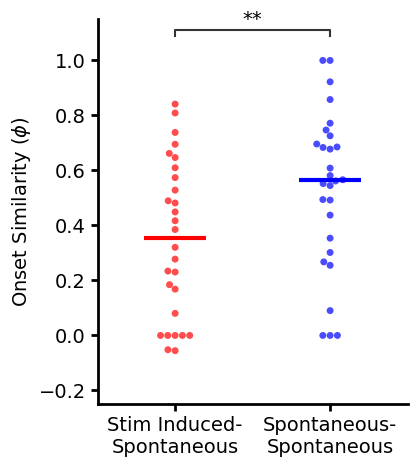

In [119]:
# Generate main channel similarity plot (Figure 3B) 
# Compares MCC (Matthews Correlation Coefficient) between stim-induced vs spontaneous seizure pairs
fig,_ = plot_seizure_similarity(ch_similarity_df,agreement='MCC',sz_level=False,typical=None,annot_stats=True,combiner=COMBINER)
fig.savefig(ospj(figpath,"figure_4_B.pdf"),bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Spontaneous: N = 12 0.68 [0.25, 0.73]
Stim: N = 12 0.02 [0.00, 0.28]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:2.461e-01 Stat=5.200e+01
Spontaneous: N = 19 0.55 [0.30, 0.61]
Stim: N = 19 0.42 [0.17, 0.61]


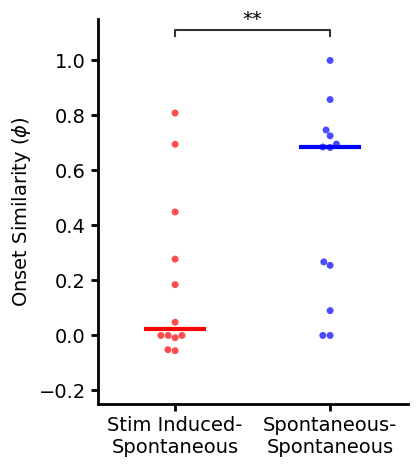

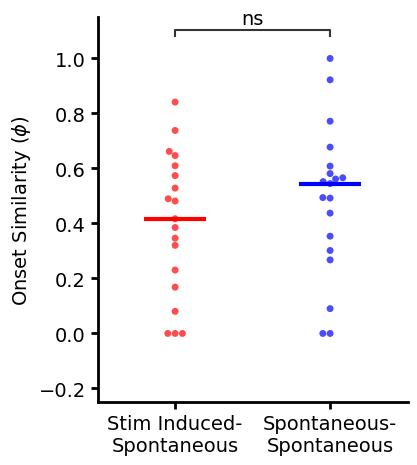

In [120]:
# Generate supplementary channel similarity plots stratified by seizure type
# Compare atypical (non-habitual) vs typical (habitual) seizures separately

# Atypical seizures only (Figure S4B)
fig,_ = plot_seizure_similarity(ch_similarity_df,agreement='MCC',sz_level=False,typical=False,combiner=COMBINER,annot_stats=True)
fig.savefig(ospj(figpath,"figure_S4_B.pdf"),bbox_inches='tight')

# Typical seizures only (Figure S4A)  
fig,_ = plot_seizure_similarity(ch_similarity_df,agreement='MCC',sz_level=False,typical=True,combiner=COMBINER,annot_stats=True)
fig.savefig(ospj(figpath,"figure_S4_A.pdf"),bbox_inches='tight')

Row 0 is stim


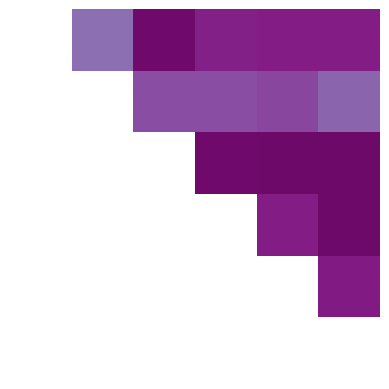

In [121]:
# Create example similarity matrix for single patient (Figure 3A)
# Shows pairwise similarity between all seizures for one representative patient

annot_type = 'ueo'  # Onset annotation type
con_type = 'strict'  # Consensus threshold
example_pt = 'HUP257'  # Representative patient

# Get all seizures for example patient and sort with stim seizures first
group = sz_annots[sz_annots.patient == example_pt]
group.sort_values(ascending=False,by='stim',inplace=True)

# Initialize similarity matrix
kappa_mat = np.zeros((len(group),len(group))); kappa_mat[:] = np.nan
group.reset_index(drop=True,inplace=True)

# Calculate pairwise similarity for all seizure combinations
for i in range(len(group)):
    ch_mask = group.loc[i,f'{annot_type}_chs_{con_type}_mask']
    if group.loc[i,'stim'] == 1:
        print(f"Row {i} is stim")  # Identify stimulation-induced seizures
    for j in range(i+1,len(group)):
        ch_mask2 = group.loc[j,f'{annot_type}_chs_{con_type}_mask']
        kappa_mat[i,j] = cohen_kappa_score(ch_mask,ch_mask2)

# Create heatmap visualization
fig,ax = plt.subplots()
plt.imshow(kappa_mat,cmap = 'BuPu')
plt.clim(0,1)  # Set color scale from 0 to 1
plt.xticks([])
plt.yticks([])
# Remove plot borders for cleaner appearance
for spine in ax.spines.values():
            spine.set_visible(False)
plt.savefig(ospj(figpath,f'figure_4_A.pdf'),bbox_inches='tight')

### Region-level seizure similarity analysis

Computing similarity metrics between seizures based on brain region involvement rather than individual channels.

In [122]:
# Calculate region-level seizure similarity using strict UEO criteria
# This compares brain region involvement patterns instead of individual channels
r_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_strict_mask',second_annot='ueo_rs_strict_mask')

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:2.610e-02 Stat=5.150e+01
Spontaneous: N = 28 0.67 [0.45, 0.79]
Stim: N = 28 0.46 [0.00, 0.65]


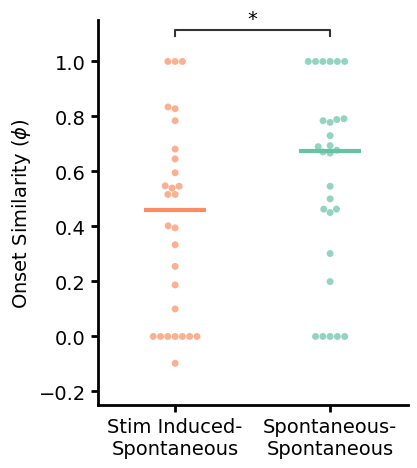

In [123]:
# Generate main region similarity plot (Figure 3C) 
# Uses custom color palette and shows regional onset similarity patterns
fig,_ = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=None,combiner=COMBINER)
fig.savefig(ospj(figpath,"figure_4_C.pdf"),bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
Spontaneous: N = 12 0.69 [0.30, 0.79]
Stim: N = 12 0.09 [0.00, 0.55]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:5.136e-01 Stat=4.850e+01
Spontaneous: N = 19 0.55 [0.30, 0.78]
Stim: N = 19 0.52 [0.10, 0.78]


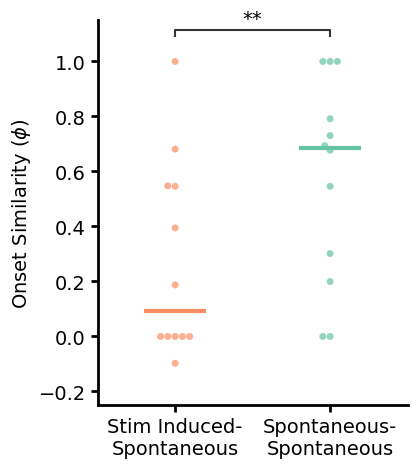

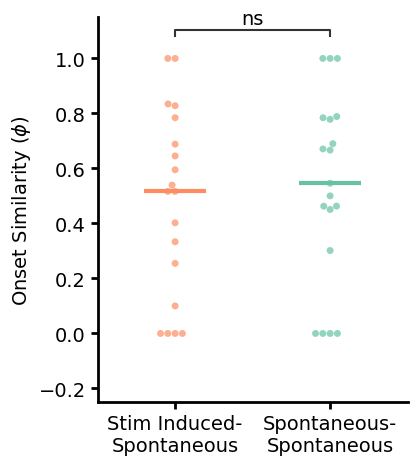

In [124]:
# Generate region similarity plots stratified by seizure semiology (Figure 4)

# Atypical (non-habitual) seizures - regional analysis (Figure 4Aii)
fig,_ = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=False,combiner=COMBINER)
fig.savefig(ospj(figpath,"figure_5_Aii.pdf"),bbox_inches='tight')

# Typical (habitual) seizures - regional analysis (Figure 4Ai)
fig,_ = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=True,combiner=COMBINER)
fig.savefig(ospj(figpath,"figure_5_Ai.pdf"),bbox_inches='tight')

### Seizure spread similarity analysis

Analyzing the temporal sequence and ranking of channel recruitment during seizure propagation.

In [125]:
# Calculate channel-level spread similarity using recruitment timing
# This compares the temporal sequence of how channels are recruited during seizures
ch_spread_df = calculate_spread_similarity(sz_annots,first_annot = 'sz_chs', second_annot = 'sz_chs', sources = 'all_channels', spread_thresh = 10, paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.416e-07 Stat=7.000e+00
Spontaneous: N = 28 0.77 [0.65, 0.82]
Stim: N = 28 0.51 [0.41, 0.66]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:4.883e-04 Stat=0.000e+00
Spontaneous: N = 12 0.73 [0.65, 0.80]
Stim: N = 12 0.40 [0.28, 0.45]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:7.248e-05 Stat=7.000e+00
Spontaneous: N = 19 0.77 [0.58, 0.83]
Stim: N = 1

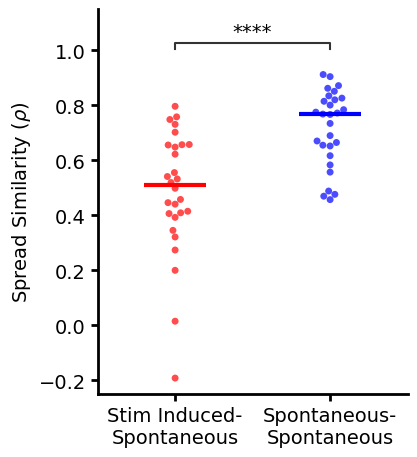

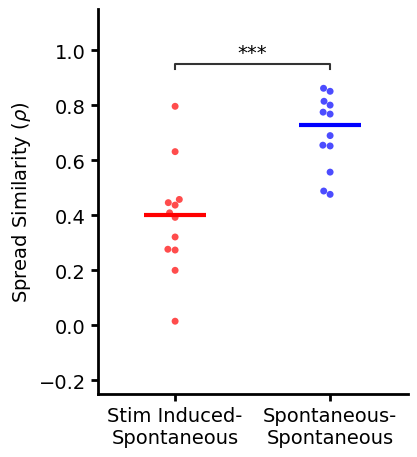

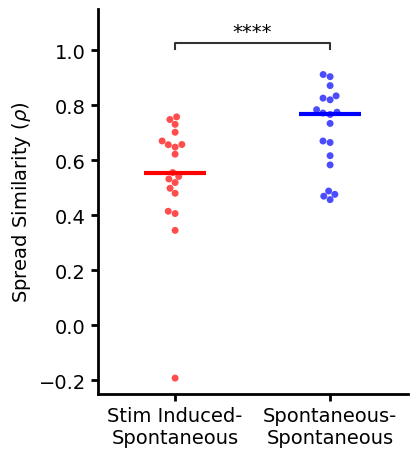

In [126]:
# Generate channel spread similarity plots (Figure S3)
# Shows correlation in channel recruitment order between seizure pairs

# All seizures - channel spread (Figure S3A)
fig,ax = plot_seizure_similarity(ch_spread_df,agreement='Rank',sz_level=False,typical=None,combiner=COMBINER)
ax.set_ylabel('Spread Similarity ($\\rho$)')
fig.savefig(ospj(figpath,"figure_S3_A.pdf"),bbox_inches='tight')

# Atypical seizures - channel spread (Figure S3Bii)
fig,ax = plot_seizure_similarity(ch_spread_df,agreement='Rank',sz_level=False,typical=False,combiner=COMBINER)
ax.set_ylabel('Spread Similarity ($\\rho$)')
fig.savefig(ospj(figpath,"figure_S3_Bii.pdf"),bbox_inches='tight')

# Typical seizures - channel spread (Figure S3Bi)
fig,ax = plot_seizure_similarity(ch_spread_df,agreement='Rank',sz_level=False,typical=True,combiner=COMBINER)
ax.set_ylabel('Spread Similarity ($\\rho$)')
fig.savefig(ospj(figpath,"figure_S3_Bi.pdf"),bbox_inches='tight')

In [127]:
# Calculate region-level spread similarity using recruitment timing
# This compares the temporal sequence of brain region recruitment during seizures
r_spread_df = calculate_spread_similarity(sz_annots_rs,first_annot = 'sz_rs', second_annot = 'sz_rs', sources = 'all_rs', spread_thresh = 10, paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.057e-04 Stat=4.400e+01
Spontaneous: N = 28 0.75 [0.60, 0.86]
Stim: N = 28 0.48 [0.39, 0.68]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.465e-03 Stat=2.000e+00
Spontaneous: N = 12 0.68 [0.51, 0.83]
Stim: N = 12 0.41 [0.36, 0.47]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:2.041e-02 Stat=3.800e+01
Spontaneous: N = 19 0.74 [0.58, 0.86]
Stim: N = 1

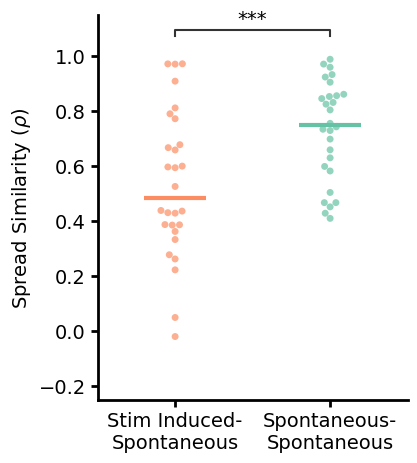

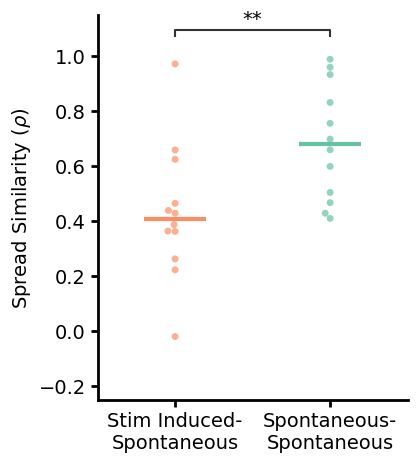

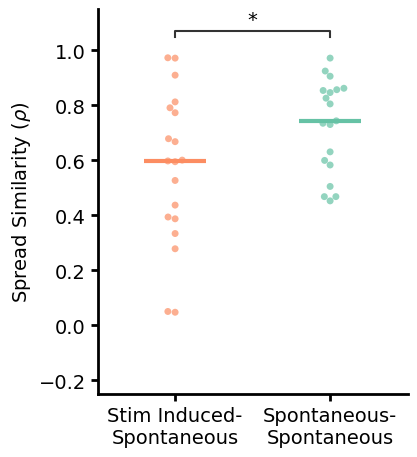

In [128]:
# Generate region spread similarity plots (Figure S3)
# Shows correlation in brain region recruitment order between seizure pairs

# All seizures - region spread (Figure S3C)
fig,ax = plot_seizure_similarity(r_spread_df,agreement='Rank',palette=pal,sz_level=False,typical=None,combiner=COMBINER)
ax.set_ylabel('Spread Similarity ($\\rho$)')
fig.savefig(ospj(figpath,"figure_S3_C.pdf"),bbox_inches='tight')

# Atypical seizures - region spread (Figure S3Dii)
fig,ax = plot_seizure_similarity(r_spread_df,agreement='Rank',palette=pal,sz_level=False,typical=False,combiner=COMBINER)
ax.set_ylabel('Spread Similarity ($\\rho$)')
fig.savefig(ospj(figpath,"figure_S3_Dii.pdf"),bbox_inches='tight')

# Typical seizures - region spread (Figure S3Di)
fig,ax = plot_seizure_similarity(r_spread_df,agreement='Rank',palette=pal,sz_level=False,typical=True,combiner=COMBINER)
ax.set_ylabel('Spread Similarity ($\\rho$)')
fig.savefig(ospj(figpath,"figure_S3_Di.pdf"),bbox_inches='tight')

## Channel Recruitment Analysis

Analyzing the proportion of electrode channels recruited during seizures, comparing stimulation-induced vs spontaneous seizures.

In [129]:
# Define functions to calculate channel recruitment percentages for different seizure components

def total_sz_recruitment(row):
    """Calculate percentage of all channels recruited during seizure"""
    szing_rs_mask = np.isin(row.all_channels,row.sz_chs)
    return sum(szing_rs_mask)/len(szing_rs_mask)*100
    
def total_onset_recruitment(row):
    """Calculate percentage of channels involved in seizure onset (UEO strict)"""
    szing_chs_mask = row.ueo_chs_strict_mask
    return sum(szing_chs_mask)/len(row.all_channels)*100

def total_nonset_recruitment(row):
    """Calculate percentage of channels involved in secondary spread (non-onset)"""
    szing_chs = np.unique(row.sz_chs)
    # Get channels involved in seizure but not in onset
    noszing_chs = szing_chs[~np.isin(szing_chs,row.ueo_chs_strict)]
    szing_chs_mask = np.isin(row.all_channels,noszing_chs)
    return sum(szing_chs_mask)/len(szing_chs_mask)*100

def pt_total_sz_recruitment(group,fun):
    """Apply recruitment function to each seizure in patient group"""
    ret_dict = dict(Recruitment=[],stim=[],patient=[])
    for _,row in group.iterrows():
        ret_dict['patient'].append(row.patient),
        ret_dict['stim'].append(bool(row.stim))  # Convert to boolean for plotting
        ret_dict['Recruitment'].append(fun(row))
        
    return pd.DataFrame(ret_dict)

#### Total channel recruitment analysis

Analyzing overall channel recruitment patterns across all seizure types.

In [130]:
# Helper function to print recruitment summary statistics
def recruitment_summary(group):
    """Print median and IQR for recruitment data by stim type"""
    x = group['Recruitment']
    N = len(x)
    med = np.round(x.median(),0)
    lower = np.round(np.nanpercentile(x,25,method='nearest'),0)
    upper = np.round(np.nanpercentile(x,75,method='nearest'),0)
    stim_label = "Stim" if group.stim.iloc[0] else "Spont"
    print(f"{stim_label}: N = {N} Med {med} [{lower}, {upper}]")
    return None

Saved total recruitment data: 441 rows
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:6.000e-05
Spont: N = 398 Med 43.0 [23.0, 54.0]
Stim: N = 43 Med 25.0 [14.0, 38.0]


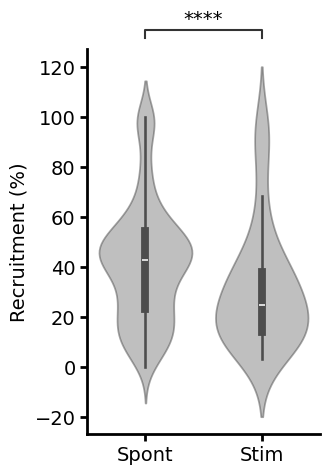

In [131]:
# Calculate and plot total channel recruitment for all seizures
# Compare stimulation-induced vs spontaneous seizures

recruitment_df = sz_annots_rs.groupby(['patient']).apply(pt_total_sz_recruitment,total_sz_recruitment)

# Save total recruitment data for external R analysis (mixed-effects modeling)
recruitment_df_total = recruitment_df.copy()
recruitment_df_total.to_csv(ospj(prodatapath,'recruitment_df_total.csv'), index=False)
print(f"Saved total recruitment data: {len(recruitment_df_total)} rows")

# Create violin plot comparing recruitment between seizure types
fig,ax = plt.subplots(figsize=(3,5))
sns.violinplot(recruitment_df,x='stim',y='Recruitment',ax=ax,alpha=0.5,color='gray')
sns.despine()

# Add statistical annotation (p-value from external R mixed-effects analysis)
annotator = Annotator(ax,[(True,False)],data=recruitment_df,x='stim',y='Recruitment')
annotator.configure(test=None, loc='outside', text_format='star', fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], 
                          [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.set_pvalues([0.00006]).annotate() # From R lme_recruitment_analysis.R

plt.xticks([0,1],['Spont','Stim'])
plt.xlabel('')
plt.ylabel('Recruitment (%)')

# Print summary statistics
recruitment_df.groupby('stim').apply(recruitment_summary);
fig.savefig(ospj(figpath,"figure_3_B.pdf"),bbox_inches='tight')

#### Onset channel recruitment analysis

Analyzing recruitment patterns specifically for seizure onset channels (UEO strict criteria).

Saved onset recruitment data: 441 rows
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:2.000e-06
Spont: N = 398 Med 5.0 [2.0, 14.0]
Stim: N = 43 Med 9.0 [5.0, 19.0]


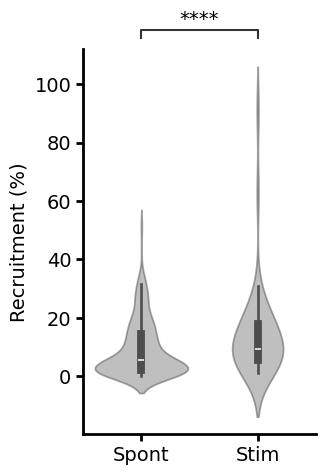

In [132]:
# Calculate and plot seizure onset channel recruitment
# Focus on channels with unequivocal electrographic onset (UEO strict)

recruitment_df = sz_annots_rs.groupby(['patient']).apply(pt_total_sz_recruitment,total_onset_recruitment)

# Save onset recruitment data for external R analysis
recruitment_df_onset = recruitment_df.copy()
recruitment_df_onset.to_csv(ospj(prodatapath,'recruitment_df_onset.csv'), index=False)
print(f"Saved onset recruitment data: {len(recruitment_df_onset)} rows")

# Create violin plot for onset channel recruitment comparison
fig,ax = plt.subplots(figsize=(3,5))
sns.violinplot(recruitment_df,x='stim',y='Recruitment',ax=ax,alpha=0.5,color='gray')
sns.despine()

# Add statistical annotation (p-value from external R mixed-effects analysis)
annotator = Annotator(ax,[(True,False)],data=recruitment_df,x='stim',y='Recruitment')
annotator.configure(test=None, loc='outside', text_format='star', fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], 
                          [0.05, "*"],[1, "ns"]])
annotator.set_pvalues([0.000002]).annotate() # From R lme_recruitment_analysis.R

plt.xticks([0,1],['Spont','Stim'])
plt.xlabel('')
plt.ylabel('Recruitment (%)')

# Print summary statistics
recruitment_df.groupby('stim').apply(recruitment_summary);
fig.savefig(ospj(figpath,"figure_3_C.pdf"),bbox_inches='tight')

#### Secondary spread channel recruitment analysis

Analyzing recruitment patterns for channels involved in seizure spread (non-onset channels).

Saved spread recruitment data: 441 rows
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:1.000e-07
Spont: N = 398 Med 26.0 [15.0, 43.0]
Stim: N = 43 Med 14.0 [8.0, 23.0]


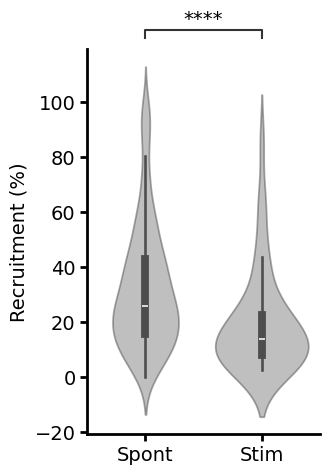

In [133]:
# Calculate and plot secondary spread channel recruitment  
# Focus on channels involved in seizure but not in initial onset

recruitment_df = sz_annots_rs.groupby(['patient']).apply(pt_total_sz_recruitment,total_nonset_recruitment)

# Save spread recruitment data for external R analysis
recruitment_df_spread = recruitment_df.copy()
recruitment_df_spread.to_csv(ospj(prodatapath,'recruitment_df_spread.csv'), index=False)
print(f"Saved spread recruitment data: {len(recruitment_df_spread)} rows")

# Create violin plot for spread channel recruitment comparison
fig,ax = plt.subplots(figsize=(3,5))
sns.violinplot(recruitment_df,x='stim',y='Recruitment',ax=ax,alpha=0.5,color='gray')
sns.despine()

# Add statistical annotation (p-value from external R mixed-effects analysis)  
annotator = Annotator(ax,[(True,False)],data=recruitment_df,x='stim',y='Recruitment')
annotator.configure(test=None, loc='outside', text_format='star', fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], 
                          [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.set_pvalues([0.0000001]).annotate() # From R lme_recruitment_analysis.R

plt.xticks([0,1],['Spont','Stim'])
plt.xlabel('')
plt.ylabel('Recruitment (%)')

# Print summary statistics
recruitment_df.groupby('stim').apply(recruitment_summary)
fig.savefig(ospj(figpath,"figure_3_D.pdf"),bbox_inches='tight')

## Seizure Spread Timing Analysis

Analyzing how stimulation onset zones are recruited during spontaneous seizures, including timing and recruitment patterns.

In [134]:
# Define functions to analyze recruitment of stimulation onset zones during spontaneous seizures
# This analysis examines whether and when channels that were stimulated (stim SOZ) are recruited 
# during spontaneous seizures, helping assess seizure propagation pathways

def analyze_spont_seizure_recruitment(sz_annots, onset='ueo_chs_strict', spread='sz_chs', source = 'all_channels'):
    """
    Analyze recruitment patterns of stimulation onset zones during spontaneous seizures.
    
    Returns two datasets:
    1. Fraction of stim SOZ channels recruited during spontaneous seizures  
    2. Timing of stim SOZ recruitment during spontaneous seizures
    """
    spread_data = []  # Store recruitment fraction data
    timing_data = []  # Store recruitment timing data

    # Process each patient separately
    for pt, group in sz_annots.groupby("patient"):
        stim_szs = group[group.stim == 1]    # Stimulation-induced seizures
        spont_szs = group[group.stim == 0]   # Spontaneous seizures

        # For each stim seizure, analyze how its onset zones are recruited in spontaneous seizures
        for _, st_sz in stim_szs.iterrows():
            # Get stimulation onset zone channels
            onset_locs = np.unique(np.array(st_sz[onset], dtype=str))
            if onset_locs.ndim == 0:
                onset_locs = np.array([onset_locs])
            
            # Fallback to earliest seizure channels if no specific onset defined
            if len(onset_locs) == 0:
                if len(st_sz.sz_times) > 0:
                    onset_time = st_sz.sz_times.min()
                    onset_locs = st_sz.sz_chs[st_sz.sz_times <= onset_time + 1]
                else:
                    print(pt,st_sz.approximate_onset)
                    continue
                    
            # Filter to only channels available in this patient's montage
            onset_locs = [o for o in onset_locs if o in st_sz[source]]
            
            # Initialize metrics for this stim seizure
            fractions = []  # Fraction recruited per spontaneous seizure
            medians = []    # Median recruitment time per spontaneous seizure
            means = []      # Mean recruitment time per spontaneous seizure
            pct25s = []     # 25th percentile recruitment time per spontaneous seizure

            # Analyze recruitment in each spontaneous seizure
            for _, sp_sz in spont_szs.iterrows():
                sp_units = np.array(sp_sz[spread], dtype=str)  # Channels involved in this spontaneous seizure
                sp_times = np.array(sp_sz.sz_times)            # Timing of channel recruitment
                if sp_units.size==0:
                    continue
                    
                # Create mapping from channel to earliest recruitment time
                unit_to_time = pd.DataFrame({
                    "unit": sp_units,
                    "time": sp_times
                }).groupby("unit")["time"].min().to_dict()
                fallback_time = np.max(sp_times)  # Late time for non-recruited channels

                # Analysis 1: Calculate fraction of stim SOZ channels recruited
                is_recruited = np.isin(onset_locs, sp_units)
                frac_recruited = np.sum(is_recruited) / len(onset_locs)
                fractions.append(frac_recruited)

                # Analysis 2: Calculate timing of stim SOZ recruitment
                # Use fallback time for channels not recruited in this spontaneous seizure
                matched_times = [unit_to_time.get(loc, fallback_time) for loc in onset_locs]
                if matched_times:
                    medians.append(np.median(matched_times))
                    means.append(np.mean(matched_times))
                    pct25s.append(np.percentile(matched_times, 25,method='nearest'))

            # Aggregate results across spontaneous seizures for this stim seizure
            typ_keys = ['Atypical','Typical']
            spread_data.append({
                "patient": pt,
                "typical": typ_keys[int(st_sz.typical)],
                "Fraction": np.percentile(fractions, 75,method='nearest')*100  # 75th percentile recruitment
            })

            if len(medians) > 0:
                timing_data.append({
                    "patient": pt,
                    "typical": typ_keys[int(st_sz.typical)],
                    "onset_median": np.median(medians),
                    "onset_mean": np.median(means),
                    "onset_med_25": np.percentile(medians,25,method='nearest')  # Early recruitment timing
                })

    return pd.DataFrame(spread_data), pd.DataFrame(timing_data)

def analyze_spont_seizure_null_recruitment(sz_annots, onset='ueo_chs_strict',spread='sz_chs', source='all_chs', 
                                            n_perm=1000, seed=2358):
    """
    Generate null distribution for recruitment analysis by randomly selecting onset zones.
    This provides statistical baseline for comparing actual stim SOZ recruitment patterns.
    """
    spread_data = []
    rng = np.random.default_rng(seed)  # Fixed seed for reproducibility

    # Process each patient separately
    for pt, group in sz_annots.groupby("patient"):
        stim_szs = group[group.stim == 1]
        spont_szs = group[group.stim == 0]

        for _, st_sz in stim_szs.iterrows():
            full_pool = np.array(st_sz[source], dtype=str)  # All available channels
            onset_pool = np.unique(st_sz[onset])
            onset_pool = np.array([o for o in onset_pool if o in full_pool])

            # Fallback for missing onset data
            if onset_pool.ndim == 0 or len(onset_pool) == 0:
                if len(st_sz.sz_times) > 0:
                    onset_time = st_sz.sz_times.min()
                    onset_pool = st_sz.sz_chs[st_sz.sz_times <= onset_time + 1]
                else:
                    continue

            # Generate n_perm random onset zone selections
            for _ in range(n_perm):
                # Randomly select same number of channels as actual onset zone
                onset_locs = rng.choice(full_pool, size=len(onset_pool), replace=False)

                fractions = []      # Recruitment fractions for this permutation
                latencies_25p = []  # Recruitment latencies for this permutation

                # Test recruitment in each spontaneous seizure
                for _, sp_sz in spont_szs.iterrows():
                    sp_units = np.array(sp_sz[spread], dtype=str)
                    sp_times = np.array(sp_sz.sz_times)

                    if sp_units.size == 0:
                        continue

                    # Map channels to recruitment times
                    unit_to_time = pd.DataFrame({
                        "unit": sp_units,
                        "time": sp_times
                    }).groupby("unit")["time"].min().to_dict()
                    fallback_time = np.max(sp_times)

                    # Calculate metrics for this random onset zone
                    is_recruited = np.isin(onset_locs, sp_units)
                    frac_recruited = np.sum(is_recruited) / len(onset_locs)
                    if np.isnan(frac_recruited):
                        print('check')
                    fractions.append(frac_recruited)

                    matched_times = [unit_to_time.get(loc, fallback_time) for loc in np.unique(onset_locs)]
                    if np.isnan(np.median(matched_times)):
                        print('med check')
                    latencies_25p.append(np.median(matched_times))

                # Store results for this permutation
                typ_keys = ['Atypical', 'Typical']
                spread_data.append({
                    "patient": pt,
                    "approximate_onset": st_sz.approximate_onset,
                    "typical": typ_keys[int(st_sz.typical)],
                    "Fraction": np.percentile(fractions, 75,method='nearest') * 100,
                    "Latency": np.percentile(latencies_25p, 25,method='nearest')
                })

    return pd.DataFrame(spread_data)

In [135]:
# Execute stimulation onset zone recruitment analysis
# This analyzes how often and when stim SOZ channels are recruited during spontaneous seizures

# Main analysis: Calculate recruitment fractions and timing for actual stim SOZs
spread_df,time_df = analyze_spont_seizure_recruitment(sz_annots,onset='ueo_chs_strict',spread='sz_chs',source='all_channels')

# Null analysis: Generate statistical baseline using 1000 random permutations
# This creates null distribution by randomly selecting onset zones of same size
null_df = analyze_spont_seizure_null_recruitment(sz_annots, onset='ueo_chs_strict',spread='sz_chs', source='all_channels', 
                                            n_perm=1000, seed=2358)

In [136]:
# null_df.to_pickle(ospj(prodatapath,'null_sz_spreadf.pkl'))
# null_df = pd.read_pickle(ospj(prodatapath,'null_sz_spreadf.pkl'))

In [137]:
# Prepare null distribution data for statistical comparison
# Add 'All' category to null data combining both typical and atypical seizures

temp_df = null_df.copy()
temp_df['typical'] = 'All'  # Create combined category for all seizure types
null_df_all = pd.concat([temp_df,null_df])

# Print summary statistics for recruitment analysis
print("Number of typical (habitual) seizures:", spread_df[spread_df.typical=='Typical'].typical.count())
print("Number of atypical (non-habitual) seizures:", spread_df[spread_df.typical=='Atypical'].typical.count())
print("Null distribution median recruitment fraction:", null_df_all[null_df_all.typical=='All'].Fraction.median())
print("Null distribution median recruitment latency:", null_df_all[null_df_all.typical=='All'].groupby(['patient','approximate_onset'])['Latency'].median().median())

Number of typical (habitual) seizures: 25
Number of atypical (non-habitual) seizures: 18
Null distribution median recruitment fraction: 56.00000000000001
Null distribution median recruitment latency: 20.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Typical vs. Atypical: Custom statistical test, P_val:5.000e-01
Permuted vs. All: Custom statistical test, P_val:4.300e-02


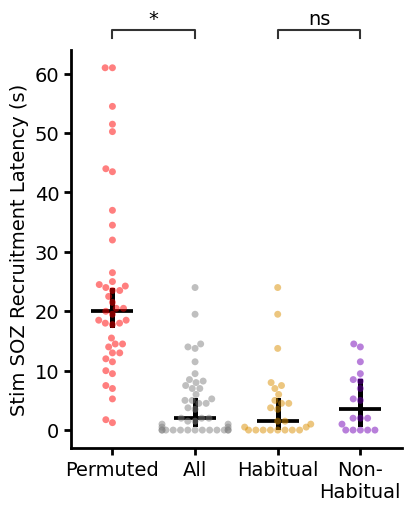

In [158]:
# Create visualization comparing stim SOZ recruitment latency across seizure types
# This plots when stim onset zones are recruited during spontaneous seizures

key = 'onset_med_25'  # Use 25th percentile of median recruitment times (early recruitment)

# Prepare timing data with 'All' category combining typical and atypical
temp_df = time_df.copy()
temp_df['typical'] = 'All'
time_df_all = pd.concat([temp_df,time_df])

# Aggregate null permutation results to median per stimulation seizure
# This creates comparable baseline statistics for each stim seizure
null_medians = null_df_all.groupby(['patient','approximate_onset'])['Latency'].median().reset_index()
null_medians['typical'] = 'Permuted'  # Label null distribution
null_medians[key] = null_medians['Latency']  # Match column naming

# Combine null and actual data for plotting
plot_df = pd.concat([null_medians, time_df_all], ignore_index=True)

# Create swarm plot comparing recruitment latencies
fig,ax = plt.subplots(figsize=(4,5),constrained_layout=True)

# Plot individual data points with categorical colors
sns.swarmplot(plot_df, x='typical', y=key, ax=ax, alpha=0.5, hue='typical', 
              order=['Permuted','All','Typical','Atypical'],
              palette=['red','gray','#da8e00','#7300b7'])

# Overlay median values as horizontal lines
sns.pointplot(plot_df, x='typical', y=key, color='black', marker='_', 
              markersize=30, order=['Permuted','All','Typical','Atypical'],
              linestyle='none', estimator='median')

# Add statistical annotations
sns.despine()
annotator = Annotator(ax,[("Atypical","Typical"),("Permuted","All")],data=plot_df,x='typical',y=key)
annotator.configure(test=None,
        comparisons_correction = None,
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [1, "ns"]],
                        )
# P-values from statistical tests (external R analysis or permutation tests)
annotator.set_pvalues([.5,.043]).annotate()

# Format plot
plt.xticks([0,1,2,3],['Permuted','All','Habitual','Non-\nHabitual'])
plt.xlabel('')
plt.ylabel('Stim SOZ Recruitment Latency (s)')
fig.savefig(ospj(figpath,'figure_6_C.pdf'))

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Typical vs. Atypical: Custom statistical test, P_val:5.000e-01
Permuted vs. All: Custom statistical test, P_val:2.000e-01


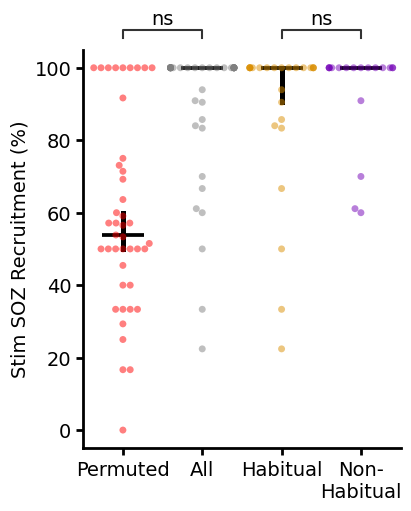

In [159]:
# Create visualization comparing stim SOZ recruitment fraction across seizure types
# This plots what percentage of stim onset zones are recruited during spontaneous seizures

key = 'Fraction'  # Percentage of stim SOZ channels recruited

# Prepare recruitment fraction data with 'All' category
temp_df = spread_df.copy()
temp_df['typical'] = 'All'
spread_df_all = pd.concat([temp_df,spread_df])

# Aggregate null permutation results to median per stimulation seizure
null_medians = null_df_all.groupby(['patient','approximate_onset'])['Fraction'].median().reset_index()
null_medians['typical'] = 'Permuted'  # Label null distribution

# Combine null and actual recruitment fraction data
plot_df = pd.concat([null_medians, spread_df_all], ignore_index=True)

# Create swarm plot comparing recruitment fractions
fig,ax = plt.subplots(figsize=(4,5),constrained_layout=True)

# Plot individual data points with categorical colors
ax = sns.swarmplot(plot_df,x='typical',y=key,ax=ax,alpha=0.5,
                   hue='typical',palette= ['red','gray','#da8e00','#7300b7'])

# Overlay median values as horizontal lines
ax = sns.pointplot(plot_df,x='typical',y=key,color='black',marker='_',
                   markersize=30,linestyle='none',estimator='median')

# Add statistical annotations
sns.despine()
annotator = Annotator(ax,[("Atypical","Typical"),("Permuted","All")],data=plot_df,x='typical',y=key)
annotator.configure(test=None,
        comparisons_correction = None,
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]],)

# P-values from statistical tests comparing groups
annotator.set_pvalues([.5,.2]).annotate()

# Format plot
plt.xticks([0,1,2,3],['Permuted','All','Habitual','Non-\nHabitual'])
plt.xlabel('')
plt.ylabel('Stim SOZ Recruitment (%)')
fig.savefig(ospj(figpath,'figure_6_B.pdf'))

In [160]:
# Perform comprehensive statistical analysis of stim SOZ recruitment patterns
# This includes Wilcoxon tests, permutation tests, and multiple comparison corrections

wil_ps = []  # Store p-values for multiple comparison correction
lat_ps = []  # Store latency p-values

# Analyze recruitment patterns for each seizure type category
for col in ['All','Typical','Atypical']:
    # Calculate summary statistics for recruitment fraction
    med_frac = spread_df_all[spread_df_all.typical == col].Fraction.median()
    frac_25 = np.percentile(spread_df_all[spread_df_all.typical==col].Fraction,25,method='nearest')
    frac_75 = np.percentile(spread_df_all[spread_df_all.typical==col].Fraction,75,method='nearest')
    
    # Calculate summary statistics for recruitment latency  
    med_lat = time_df_all[time_df_all.typical==col].onset_med_25.median()
    
    # Wilcoxon signed-rank test: are latencies significantly different from 10s?
    # This tests if stim SOZs are recruited earlier than expected by chance
    stat,p = sc.stats.wilcoxon(time_df_all[time_df_all.typical==col].onset_med_25-10)
    print(f"{col} Wilcoxon test vs 10s: p={p}, stat={stat}")
    wil_ps.append(p)
    
    # Calculate latency quartiles
    lat_25 = np.percentile(time_df_all[time_df_all.typical==col].onset_med_25,25,method='nearest')
    lat_75 = np.percentile(time_df_all[time_df_all.typical==col].onset_med_25,75,method='nearest')
    
    # Permutation test p-values (compare to null distribution)
    key = 'All'
    lat_pval = 'None'
    frac_pval = 'None'
    
    if col == 'All':
        # Calculate permutation test p-values
        # Fraction: How often null distribution >= observed fraction
        frac_pval = (np.sum(null_df_all[null_df_all.typical==key].Fraction >= med_frac)+1)/(len(null_df_all[null_df_all.typical==key])+1)
        # Latency: How often null distribution <= observed latency (shorter = more significant)
        lat_pval = (np.sum(null_df_all[null_df_all.typical==key].Latency <= med_lat)+1)/(len(null_df_all[null_df_all.typical==key])+1)
    
    # Print summary results
    print(f"{col} Latency - {med_lat} ({lat_25},{lat_75}) pval = {lat_pval}")
    print(f"{col} Fraction - {med_frac} ({frac_25},{frac_75}) pval = {frac_pval}")

# Apply Bonferroni correction for multiple comparisons
print("Bonferroni correction results:", multipletests(wil_ps,method='bonf'))

# Export data for external statistical analysis in R
# These datasets enable mixed-effects modeling accounting for patient-level clustering
time_df_all.to_csv(ospj(prodatapath,'time_df_all.csv'), index=False)
spread_df_all.to_csv(ospj(prodatapath,'spread_df_all.csv'), index=False)
null_df_all.to_csv(ospj(prodatapath,'null_df_all.csv'), index=False)

print(f"\nSaved dataframes for external R analysis:")
print(f"- time_df_all: {len(time_df_all)} rows (recruitment timing data)")
print(f"- spread_df_all: {len(spread_df_all)} rows (recruitment fraction data)") 
print(f"- null_df_all: {len(null_df_all)} rows (null distribution for permutation testing)")

All Wilcoxon test vs 10s: p=8.23392889177765e-06, stat=105.0
All Latency - 2.0 (0.0,7.5) pval = 0.039371177414478736
All Fraction - 100.0 (90.47619047619048,100.0) pval = 0.22713425269179788
Typical Wilcoxon test vs 10s: p=0.0013669812234939041, stat=44.0
Typical Latency - 1.5 (0.0,6.0) pval = None
Typical Fraction - 100.0 (85.71428571428571,100.0) pval = None
Atypical Wilcoxon test vs 10s: p=0.0022311753610925983, stat=15.5
Atypical Latency - 3.5 (0.0,8.5) pval = None
Atypical Fraction - 100.0 (100.0,100.0) pval = None
Bonferroni correction results: (array([ True,  True,  True]), array([2.47017867e-05, 4.10094367e-03, 6.69352608e-03]), np.float64(0.016952427508441503), 0.016666666666666666)

Saved dataframes for external R analysis:
- time_df_all: 86 rows (recruitment timing data)
- spread_df_all: 86 rows (recruitment fraction data)
- null_df_all: 86000 rows (null distribution for permutation testing)


## Predicting Electrographic Similarity

### Calculating seizure level metadata

#### Seizure similarity

In [141]:
# Define function to calculate seizure similarity metrics for predictive modeling
# This function computes pairwise similarity between stimulation-induced and spontaneous seizures
# focusing on seizure onset patterns for use as dependent variables in statistical models

def model_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    """
    Calculate seizure similarity metrics between stimulation-induced and spontaneous seizures.
    
    This function differs from the earlier similarity analysis by:
    1. Only comparing stim seizures to spontaneous seizures (not stim-stim pairs)
    2. Collecting metadata for each stimulation seizure for predictive modeling
    3. Computing multiple similarity metrics (kappa, F1, MCC) for robust analysis
    
    Returns: DataFrame with similarity metrics and seizure metadata for modeling
    """
    # Initialize storage for similarity metrics and metadata
    annot_list = ["kappa","F1","MCC","patient","IEEGname","approximate_onset"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []  # Track patients excluded due to insufficient data
    
    # Process each patient separately
    for pt,group in annots.groupby("patient"):
        # Quality control: ensure sufficient spontaneous seizures for comparison
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:  # Need at least 2 seizures total
            skip_pt.append(pt)
            continue
            
        # Calculate similarity for each stimulation seizure vs all spontaneous seizures
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            
            # Only process stimulation-induced seizures as reference
            if group.loc[i,'stim'] == 1:
                ch_mask = group.loc[i,first_annot].reshape(-1,)  # Stim seizure onset pattern
                
                # Compare this stim seizure to all other seizures in the patient
                for j in range(len(group)):
                    # Skip stim-stim comparisons (focus on stim vs spontaneous)
                    if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1):
                        continue
                        
                    # Calculate similarity metrics with comparison seizure
                    ch_mask2 = group.loc[j,second_annot].reshape(-1,)
                    
                    # Store multiple similarity metrics for robust analysis
                    annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))        # Agreement correcting for chance
                    annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))                    # Harmonic mean of precision/recall
                    annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))          # Balanced metric for binary classification
                    
                    # Store metadata for this stimulation seizure
                    annot_dict["patient"].append(pt)
                    annot_dict["IEEGname"].append(group.loc[i,'iEEG_ID'])
                    annot_dict["approximate_onset"].append(group.loc[i,'approximate_onset'])
                    
    # Convert to DataFrame for analysis                
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

In [142]:
# Calculate seizure similarity metrics for predictive modeling
# Using region-level onset patterns (strict UEO criteria) for stim vs spontaneous comparisons

# Compute similarity metrics: kappa, F1, and MCC for region-based seizure onset patterns
# paired=False allows including patients with only one spontaneous seizure
model_df = model_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_strict_mask',second_annot='ueo_rs_strict_mask',paired = False)

# Standardize column naming for downstream merging
model_df = model_df.rename(columns={'IEEGname':'iEEG_ID'})

# Sort by seizure onset time for temporal analysis
model_df = model_df.sort_values('approximate_onset')

# Display number of patients included in modeling dataset
print("Patients included in similarity modeling:", model_df.patient.nunique())

Skipped [] due to insufficient spontaneous seizures
Patients included in similarity modeling: 30


#### Merging with metadata

In [143]:
# Merge similarity metrics with clinical seizure metadata
# Add seizure semiology information (typical/atypical) to similarity data for modeling

# Use temporal merge to match seizure similarity data with clinical annotations
# tolerance=240 allows 4-minute matching window for slight timing discrepancies
model_df_wtypical = pd.merge_asof(model_df,
                                    seizures_df[['approximate_onset','patient',"iEEG_ID","to_annotate","typical"]],
                                    on='approximate_onset',by=['patient','iEEG_ID'],
                                    tolerance = 240,  # 4-minute tolerance window
                                    direction='nearest')  # Match to nearest seizure in time

In [144]:
# Convert typical seizure coding from numeric to boolean
# 1 = typical (habitual) seizure, 0 = atypical (non-habitual) seizure
model_df_wtypical.typical = model_df_wtypical.typical == 1

In [145]:
# Load and process HUP (Hospital of University of Pennsylvania) patient metadata
# This includes clinical characteristics for predictive modeling of seizure similarity

# Load patient table and clinical metadata from BIDS-formatted files
patient_table = Config.deal(['patient_table'],flag='HUP')
metadata_table = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata-4.csv')).loc[:,["hupsubjno",
                                                                                            "unifocal",
                                                                                            "localization","duration",
                                                                                            "outcome","lesional","age_at_onset"]]

# Create binary indicator for patients who had stimulation seizures
metadata_table['stim_sz'] = metadata_table['hupsubjno'].apply(int).isin(patient_table.ptID.apply(lambda x: int(x[3:])))

# Process seizure onset zone localization
# MTLE = Mesial Temporal Lobe Epilepsy (common focal epilepsy syndrome)
metadata_table['mtle'] = metadata_table.localization.apply(lambda x: 'MTLE' in x if not isinstance(x,float) else False)

# Convert numeric coding to boolean for key clinical variables
metadata_table["unifocal"] = metadata_table.unifocal == 1      # Single seizure focus vs multifocal
metadata_table["lesional"] = metadata_table.lesional > 0       # Presence of structural brain lesion

# Create standardized patient ID format
metadata_table["ptID"] = "HUP" + metadata_table["hupsubjno"].astype(str)

In [146]:
# Load and process CHOP (Children's Hospital of Philadelphia) patient metadata
# This provides pediatric patient characteristics to complement adult HUP data

# Load pediatric metadata and standardize column naming
kiddata_table = pd.read_csv(ospj(metapath,'CHOP_metadata.csv'))

# Standardize column names to match HUP metadata structure
kiddata_table['duration'] = kiddata_table['duration of epilepsy prior to stim (y)']  # Epilepsy duration before stimulation
kiddata_table['age_at_onset'] = kiddata_table['age at epilepsy onset']               # Age when epilepsy started

# Convert binary variables from numeric to boolean (consistent with HUP processing)
kiddata_table['unifocal'] = kiddata_table.unifocal == 1     # Single seizure focus
kiddata_table['mtle'] = kiddata_table.mtle == 1             # Mesial temporal lobe epilepsy
kiddata_table['lesional'] = kiddata_table.lesional == 1     # Structural brain lesion present

In [147]:
# Combine HUP and CHOP metadata into unified dataset for cross-center analysis
# This creates consistent clinical variables across adult and pediatric populations

# Concatenate adult (HUP) and pediatric (CHOP) metadata with standardized columns
all_metadata_table = pd.concat((metadata_table,kiddata_table))[['ptID','unifocal','mtle','outcome','duration','age_at_onset','lesional','stim_sz']]

# Add center indicator: True=HUP (adult), False=CHOP (pediatric)
all_metadata_table['adult'] = all_metadata_table.ptID.apply(lambda x: 'HUP' in x)

# Calculate age at electrode implantation (onset age + epilepsy duration)
all_metadata_table['age'] = all_metadata_table['age_at_onset'] + all_metadata_table['duration']

# Display sample of combined metadata
all_metadata_table.head()

,ptID,unifocal,mtle,outcome,duration,age_at_onset,lesional,stim_sz,adult,age
0,HUP211,False,True,NaN,11.3,12.0,True,0,True,23.3
1,HUP212,False,False,NaN,13.9,42.0,True,0,True,55.9
2,HUP213,True,True,NaN,19.1,2.0,True,0,True,21.1
3,HUP214,False,True,NaN,8.6,32.0,False,0,True,40.6
4,HUP216,True,False,1.0,21.1,3.0,False,0,True,24.1


In [148]:
# Aggregate multiple similarity comparisons per seizure into single representative values
# Each stimulation seizure has multiple similarity scores (vs each spontaneous seizure)
# Aggregate to one score per stim seizure for statistical modeling

def percentile(x,combiner=COMBINER):
    """Apply 75th percentile aggregation to similarity scores"""
    return np.percentile(x,combiner,method='nearest')

# Group by seizure onset time to aggregate multiple comparisons per stim seizure
model_df_grouped = model_df_wtypical.groupby('approximate_onset')

# For metadata columns, take maximum value (should be identical within group)
model_df_left = model_df_grouped[[l for l in model_df_wtypical.columns if l not in ['MCC','F1','kappa']]].max()

# For similarity metrics, use 75th percentile (emphasizes higher similarity comparisons)
# This captures the strongest similarity between stim and spontaneous seizures
model_df_left['MCC'] = model_df_grouped['MCC'].apply(percentile)    # Matthews Correlation Coefficient
model_df_left['F1'] = model_df_grouped['F1'].apply(percentile)      # F1 score
model_df_left['kappa'] = model_df_grouped['kappa'].apply(percentile) # Cohen's kappa


In [149]:
# Create final modeling dataset by merging seizure similarity with clinical metadata
# This combines electrographic similarity metrics with patient characteristics for statistical modeling

# Merge similarity data with clinical metadata using patient ID
lm_df_left = pd.merge(model_df_left,
                      all_metadata_table[['ptID','mtle','outcome','unifocal','lesional','adult','duration','age_at_onset','age']],
                      left_on='patient',right_on='ptID',how='inner').drop('ptID',axis=1)

# Remove rows with missing data in key modeling variables
# This ensures complete cases for statistical analysis
lm_df_left.dropna(axis=0,subset=['MCC','F1','mtle','unifocal','typical','lesional'],how='any',inplace=True)

# Save final modeling dataset for analysis in R or other statistical software
lm_df_left.to_csv(ospj(prodatapath,'modeling_df.csv'),index=False)

### Univariate Plotting

In [150]:
# Define utility functions for univariate analysis of clinical predictors
# These functions support statistical testing and visualization of factors predicting seizure similarity

def univariate_summary(group):
    """Print summary statistics for MCC (seizure similarity) by group"""
    x = group['MCC']
    med = np.round(x.median(),2)
    lower = np.round(np.nanpercentile(x,25,method='nearest'),2)
    upper = np.round(np.nanpercentile(x,75,method='nearest'),2)
    print(f"N = {len(x)} Med {med} [{lower}, {upper}]")
    return None
    
def univariate_mixed_effects_test(data, variable, outcome='MCC', patient_col='patient'):
    """
    Perform mixed-effects model test for a binary predictor with random intercept for patient.
    This accounts for patient-level clustering in the data while testing clinical predictors.
    """
    try:
        # Fit mixed-effects model: MCC ~ variable + (1|patient)
        # This accounts for correlation within patients (multiple seizures per patient)
        formula = f'{outcome} ~ {variable}'
        model = MixedLM.from_formula(formula, data=data, groups=data[patient_col])
        fit = model.fit()
        
        # Extract coefficient for the variable (skip intercept)
        param_names = list(fit.params.index)
        var_param = [p for p in param_names if variable in p and p != 'Intercept'][0]
        
        # Extract test statistics
        z_val = fit.tvalues[var_param]
        ci_low, ci_high = fit.conf_int().loc[var_param]
        
        # Kenward-Roger approximation for more accurate degrees of freedom
        # This improves small-sample inference for mixed-effects models
        n_obs = len(data)
        n_groups = data['patient'].nunique()
        n_fixed_params = len(fit.params)
        
        # Conservative KR approximation: N - n_groups - n_fixed_params
        kr_ddf = n_obs - n_groups - n_fixed_params
        
        # Convert z-statistic to t-statistic and calculate KR-corrected p-value
        t_stat = z_val  # For large samples, z ≈ t
        kr_pval = 2 * (1 - stats.t.cdf(abs(t_stat), kr_ddf))
        
        # Handle different parameter naming conventions
        variable_effect = None
        for param in fit.params.index:
            if variable in param and param != 'Intercept':
                variable_effect = param
                break
        
        if variable_effect is None:
            print(f"Warning: Could not find parameter for {variable}")
            return {'pvalue': np.nan, 'coefficient': np.nan, 'model_fit': None}
        
        # Extract final statistics
        pvalue = fit.pvalues[variable_effect]
        coef = fit.params[variable_effect]
        
        return {
            'pvalue': pvalue,
            'kr_pval': kr_pval,           # Kenward-Roger corrected p-value
            'kr_dof': kr_ddf,             # Corrected degrees of freedom
            'coefficient': coef,
            'ci': (ci_low, ci_high),
            'model_fit': fit,
            'parameter_name': variable_effect
        }
    except Exception as e:
        print(f"Error fitting model for {variable}: {str(e)}")
        return {'pvalue': np.nan, 'coefficient': np.nan, 'model_fit': None}



=== MTLE UNIVARIATE ANALYSIS ===
N = 15 Med 0.4 [0.0, 0.55]
N = 28 Med 0.45 [0.1, 0.69]


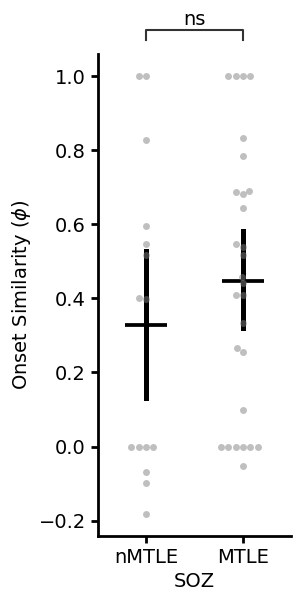


=== ADULT UNIVARIATE ANALYSIS ===
N = 20 Med 0.49 [0.25, 0.69]
N = 23 Med 0.41 [0.0, 0.65]


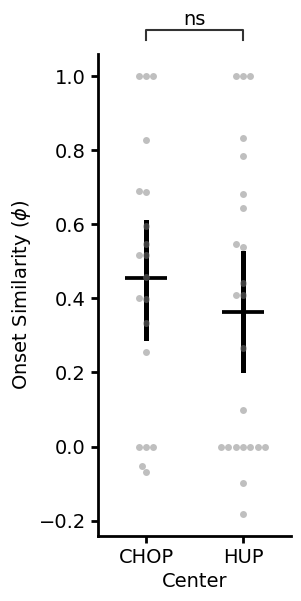


=== TYPICAL UNIVARIATE ANALYSIS ===
N = 18 Med 0.0 [0.0, 0.41]
N = 25 Med 0.54 [0.33, 0.83]


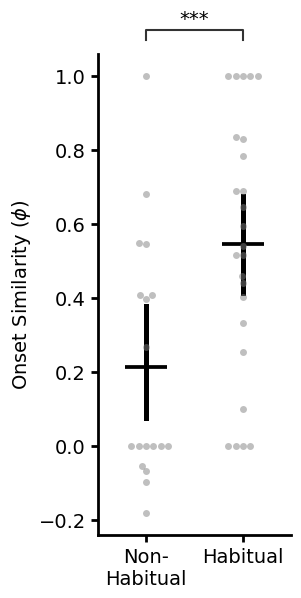

In [151]:
# Perform univariate analysis of clinical predictors of seizure onset similarity
# Test how clinical variables (MTLE, center, seizure type) affect stim-spontaneous similarity

# Analyze key binary clinical predictors
for col in ['mtle','adult','typical']:
    if lm_df_left[col].nunique() <= 3:  # Only analyze binary/categorical variables
        print(f"\n=== {col.upper()} UNIVARIATE ANALYSIS ===")
        
        # Print summary statistics by group
        lm_df_left.groupby(col).apply(univariate_summary)
        
        # Perform mixed-effects statistical test accounting for patient clustering
        mixed_results = univariate_mixed_effects_test(lm_df_left, col)
        
        # Create swarm plot showing individual data points and group means
        _,ax = plt.subplots(figsize=(2.5,6.25))
        sns.swarmplot(lm_df_left,x=col,y='MCC',color='gray',alpha=0.5,ax=ax)
        sns.pointplot(lm_df_left,x=col,y='MCC',marker='_',linestyles='none',markersize=30,color='black',ax=ax,estimator='mean')
        plt.ylabel('Onset Similarity ($\phi$)')  # Using MCC (Matthews Correlation Coefficient)
        sns.despine()

        # Customize plots and add statistical annotations for each predictor
        if col == 'typical':
            # Seizure semiology: typical (habitual) vs atypical (non-habitual)
            plt.xticks([0,1],['Non-\nHabitual','Habitual'])
            plt.xlabel('')
            annotator = Annotator(ax,[(False,True)],data=lm_df_left,x=col,y='MCC')
            (annotator
            .configure(test=None,
            loc='outside',
            text_format='star',
            fontsize=14,
            pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                            [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]],
            verbose=False)
            .set_pvalues([0.001])  # P-value from external R mixed-effects model
            .annotate()
            )
            plt.savefig(ospj(figpath,'figure_5_B.pdf'),bbox_inches='tight')
        
        if col == 'mtle':
            # Seizure onset zone localization: MTLE vs non-MTLE
            plt.close()
            _,ax = plt.subplots(figsize=(2.5,6.25))
            sns.swarmplot(lm_df_left,x=col,y='MCC',color='gray',alpha=0.5,ax=ax)
            sns.pointplot(lm_df_left,x=col,y='MCC',marker='_',linestyles='none',markersize=30,color='black',ax=ax,estimator='mean')
            plt.ylabel('Onset Similarity ($\phi$)')
            sns.despine()
            plt.xticks([0,1],['nMTLE','MTLE'])  # Non-MTLE vs MTLE
            plt.xlabel('SOZ')  # Seizure Onset Zone
            annotator = Annotator(ax,[(False,True)],data=lm_df_left,x=col,y='MCC')
            (annotator
            .configure(test=None,
            loc='outside',
            text_format='star',
            fontsize=14,
            pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                            [1e-2, "**"], [0.05, "*"], [1, "ns"]],
            verbose=False)
            .set_pvalues([0.14])  # P-value from external R mixed-effects model
            .annotate()
            )
            plt.savefig(ospj(figpath,'figure_7_C.pdf'),bbox_inches='tight')
            
        if col == 'adult':
            # Medical center: pediatric (CHOP) vs adult (HUP) 
            plt.xticks([0,1],['CHOP','HUP'],rotation=0)
            plt.xlabel('Center')
            annotator = Annotator(ax,[(False,True)],data=lm_df_left,x=col,y='MCC')
            (annotator
            .configure(test=None,
            loc='outside',
            text_format='star',
            fontsize=14,
            pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                            [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]],   
            verbose=False)
            .set_pvalues([mixed_results['kr_pval']])  # Use Kenward-Roger corrected p-value
            .annotate()
            )
    plt.show()

### Semiology

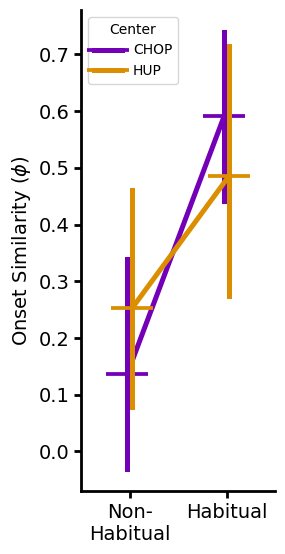

In [152]:
# Create interaction plot showing seizure semiology effects by medical center
# This explores whether center differences interact with seizure type patterns

# Prepare data with readable center labels
plot_df = lm_df_left.copy()
plot_df['adult'] = plot_df.adult.map({True:'HUP',False:'CHOP'})  # Convert boolean to center names

# Create point plot showing mean similarity by seizure type and center
_,ax = plt.subplots(figsize=(2.5,6.25))
sns.pointplot(
    data = plot_df,
    x='typical',
    y='MCC',
    hue='adult',                    # Separate lines for each center
    marker='_',markersize=30,
    palette=['#7300b7','#da8e00'],  # Purple for CHOP, orange for HUP
    ax=ax,
    dodge=True,                     # Offset points to avoid overlap
    )

# Format plot
plt.ylabel('Onset Similarity ($\phi$)')
sns.despine()
plt.xticks([0,1],['Non-\nHabitual','Habitual'])
plt.legend(title='Center')
plt.xlabel('')
plt.savefig(ospj(figpath,'figure_5_C.pdf'),bbox_inches='tight')

### Localization

#### Center effects

In [153]:
# Fit interaction model testing center and localization effects on similarity
# Tests whether center differences depend on seizure onset zone localization (MTLE vs non-MTLE)

# OLS model: MCC ~ center * localization + interaction
center_mdl = smf.ols(formula='MCC ~ adult*mtle',data=lm_df_left).fit()
print("=== CENTER × LOCALIZATION INTERACTION MODEL ===")
print(center_mdl.summary())

=== CENTER × LOCALIZATION INTERACTION MODEL ===
                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     3.997
Date:                Tue, 26 Aug 2025   Prob (F-statistic):             0.0142
Time:                        12:55:26   Log-Likelihood:                -12.402
No. Observations:                  43   AIC:                             32.80
Df Residuals:                      39   BIC:                             39.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

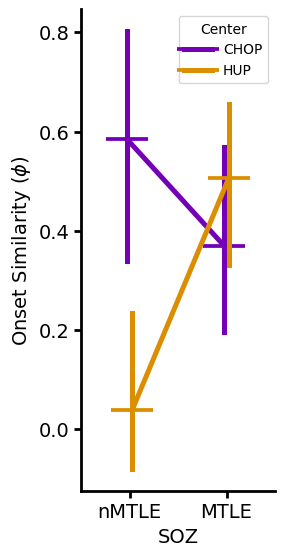

In [154]:
# Visualize center × localization interaction from the previous model
# Shows how MTLE vs non-MTLE effects differ between HUP and CHOP

# Prepare data with readable center labels
plot_df = lm_df_left.copy()
plot_df['adult'] = plot_df.adult.map({True:'HUP',False:'CHOP'})

# Create interaction plot: MTLE/non-MTLE by center
_,ax = plt.subplots(figsize=(2.5,6.25))
sns.pointplot(
    data = plot_df,
    x='mtle',
    y='MCC',
    hue='adult',                    # Separate lines for each center
    marker='_',markersize=30,
    palette=['#7300b7','#da8e00'],  # CHOP=purple, HUP=orange
    ax=ax,
    dodge=True,
    )

# Format plot
plt.ylabel('Onset Similarity ($\phi$)')
sns.despine()
plt.xticks([0,1],['nMTLE','MTLE'])  # Non-MTLE vs MTLE localization
plt.xlabel('SOZ')                   # Seizure Onset Zone
plt.legend(title='Center')
# plt.savefig(ospj(figpath,'stim_univariate_mtle_by_center.pdf'),bbox_inches='tight')
print()

#### Age effects

In [155]:
# Create dichotomized age variables for interaction modeling
# Split continuous age variables at median to test threshold effects

# Calculate median splits for different age measures
onset_split = lm_df_left.age_at_onset.median(); print("Median age at epilepsy onset:",onset_split, "years")
dur_split = lm_df_left.duration.median()
age_split = lm_df_left.age.median()

# Create binary age variables with descriptive labels
lm_df_left['onset_age'] = (lm_df_left.age_at_onset>onset_split).map({False:f'$\leq${int(onset_split)}',True:f'>{int(onset_split)}'})           # Early vs late epilepsy onset
lm_df_left['epilepsy_duration'] = (lm_df_left.duration>dur_split).map({False:f'$\leq${int(dur_split)}',True:f'>{int(dur_split)}'})              # Short vs long epilepsy duration  
lm_df_left['implant_age'] = (lm_df_left.age>age_split).map({False:f'$\leq${int(age_split)}',True:f'>{int(age_split)}'})                        # Younger vs older at implantation

Median age at epilepsy onset: 14.0 years


In [156]:
# Test interaction models for different age measures with seizure localization
# Examines whether MTLE effects depend on patient age characteristics

# Fit three interaction models testing different age measures
age_mdl = smf.ols(formula='MCC ~mtle*implant_age',data=lm_df_left).fit()        # Age at electrode implantation × MTLE
dur_mdl = smf.ols(formula='MCC ~ mtle*epilepsy_duration',data=lm_df_left).fit() # Epilepsy duration × MTLE  
onset_mdl = smf.ols(formula='MCC ~ mtle*onset_age',data=lm_df_left).fit()       # Age at epilepsy onset × MTLE

# Compare model fits (R² and overall p-values)
print("=== AGE INTERACTION MODEL COMPARISON ===")
print(f"Implant age model:     R² = {age_mdl.rsquared:.3f}, p = {age_mdl.f_pvalue:.3f}")
print(f"Epilepsy duration model: R² = {dur_mdl.rsquared:.3f}, p = {dur_mdl.f_pvalue:.3f}")
print(f"Onset age model:       R² = {onset_mdl.rsquared:.3f}, p = {onset_mdl.f_pvalue:.3f}")

# Display best-fitting model (onset age × MTLE interaction)
print("\n=== BEST MODEL: ONSET AGE × MTLE INTERACTION ===")
print(onset_mdl.summary())

=== AGE INTERACTION MODEL COMPARISON ===
Implant age model:     R² = 0.169, p = 0.062
Epilepsy duration model: R² = 0.056, p = 0.514
Onset age model:       R² = 0.307, p = 0.002

=== BEST MODEL: ONSET AGE × MTLE INTERACTION ===
                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     5.771
Date:                Tue, 26 Aug 2025   Prob (F-statistic):            0.00229
Time:                        12:55:26   Log-Likelihood:                -10.268
No. Observations:                  43   AIC:                             28.54
Df Residuals:                      39   BIC:                             35.58
Df Model:                           3                                         
Covariance Type:            nonrobust                        

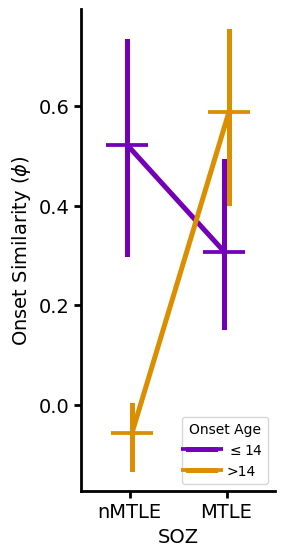

In [157]:
# Visualize the significant onset age × MTLE interaction from the best-fitting model
# Shows how MTLE effects on similarity differ between early and late epilepsy onset

# Create onset age variable for plotting (same split as in model)
split = plot_df.age_at_onset.median()
plot_df['onset_age'] = (lm_df_left.age_at_onset>split).map({False:f'$\leq${int(split)}',True:f'>{int(split)}'})

# Create interaction plot: MTLE/non-MTLE by age at epilepsy onset
_,ax = plt.subplots(figsize=(2.5,6.25))
sns.pointplot(
    data = plot_df,
    x='mtle',
    y='MCC',
    hue='onset_age',               # Separate lines for early vs late onset
    marker='_',markersize=30,
    palette=['#7300b7','#da8e00'], # Purple for ≤14 years, orange for >14 years
    ax=ax,
    dodge=True,
    )

# Format plot
plt.ylabel('Onset Similarity ($\phi$)')
sns.despine()
plt.xticks([0,1],['nMTLE','MTLE'])     # Non-MTLE vs MTLE localization
plt.xlabel('SOZ')                      # Seizure Onset Zone
plt.legend(title='Onset Age')
plt.savefig(ospj(figpath,'figure_7_D.pdf'),bbox_inches='tight')